In [94]:
import sys
sys.path.insert(0, 'utils')
from matplotlib.font_manager import FontProperties
import pandas as pd
import numpy as np
import seaborn as sns
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as metrics
import ds_charts as ds
from ds_charts import plot_evaluation_results
import itertools as it
import timeit
import os



%matplotlib inline

In [109]:

dataset = 'covid/America'
suffix = 'covid_dankfe3'
file_name = ''

data_dir = f'data/{dataset}/'
image_dir = f'images/{dataset}/{suffix}/'

if not os.path.exists(data_dir):
        os.mkdir(data_dir)
if not os.path.exists(image_dir):
        os.mkdir(image_dir)

train_test_avaliable = True

if train_test_avaliable:
        train = pd.read_csv(f'{data_dir}{file_name}{suffix}_train.csv',parse_dates=['current_date'], infer_datetime_format=True)
        test = pd.read_csv(f'{data_dir}{file_name}{suffix}_test.csv',parse_dates=['current_date'], infer_datetime_format=True)
else:
        train = pd.read_csv(f'{data_dir}{file_name}{suffix}.csv',parse_dates=['current_date'], infer_datetime_format=True)

In [111]:
# Tratamento de missing values

le = LabelEncoder()

# train = train.drop(columns=['ratio'])
# train = train.dropna(subset=['high_risk_2w'])
# train = train.dropna(subset=['renewable_percentage'])

variable_types = ds.get_variable_types(train)
print(variable_types)

train = train.drop(columns=variable_types['Date'])
train['country'] = le.fit_transform(train['country'])
train['first_date'] = le.fit_transform(train['first_date'])
#train['city'] = le.fit_transform(train['city'])
# train['weapon'] = le.fit_transform(train['weapon'])
# train['district'] = le.fit_transform(train['district'])
# train['neighborhood'] = le.fit_transform(train['neighborhood'])
# train['description'] = le.fit_transform(train['description'])
#train = train.dropna(subset=['last_year_temp'])
#train = train.dropna(subset=['one_year_diff'])
print(train.isna().sum()[train.isna().sum() != 0])
print(train.iloc[0])

if train_test_avaliable:
    test = test.drop(columns=variable_types['Date'])
    test['country'] = le.fit_transform(test['country'])
    test['first_date'] = le.fit_transform(test['first_date'])
    #test['city'] = le.fit_transform(test['city'])
    # test['weapon'] = le.fit_transform(test['weapon'])
    # test['district'] = le.fit_transform(test['district'])
    # test['description'] = le.fit_transform(test['description'])
    # train['neighborhood'] = le.fit_transform(train['neighborhood'])
    # test['neighborhood'] = le.fit_transform(test['neighborhood'])
    #test = test.dropna(subset=['last_year_temp'])
    #test = test.dropna(subset=['one_year_diff'])
    print(test.isna().sum()[test.isna().sum() != 0])



{'Numeric': ['cases', 'deaths', 'population', 'nr_months', 'ratio', 'cases_100k', 'avg_2weeks', 'avg_2w_100k', 'sum_2weeks', 'sum_2w_100k', 'current_date_day', 'current_date_month', 'current_date_season', 'current_date_weekday', 'cases_mean_per_country', 'cases_std_per_country', 'cases_median_per_country', 'cases_max_per_country', 'cases_min_per_country', 'deaths_mean_per_country', 'deaths_std_per_country', 'deaths_median_per_country', 'deaths_max_per_country', 'deaths_min_per_country'], 'Binary': ['high_risk_2w', 'current_risk', 'current_date_year'], 'Date': [], 'Symbolic': ['country', 'first_date']}
Series([], dtype: int64)
cases                        2.271884
deaths                         2.2848
population                   2.963968
nr_months                    1.926807
ratio                        0.044355
cases_100k                    0.74864
avg_2weeks                   2.379338
avg_2w_100k                   0.87256
sum_2weeks                   2.379342
sum_2w_100k             

In [112]:
target = 'high_risk_2w'
positive = True
negative = False

if train_test_avaliable:
    trnY: np.ndarray = train.pop(target).values
    trnX: np.ndarray = train.values
    tstY: np.ndarray = test.pop(target).values
    tstX: np.ndarray = test.values
    labels: np.ndarray = pd.unique(trnY)
else:
    y = train.pop(target).values
    X = train.values
    labels: np.ndarray = pd.unique(y)

model_scores = {
    'NB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'KNN': {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'DT':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'RF':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'GB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
}

In [113]:
# TEST CONFIGURATIONS
train_config = {
    'KNN' : True,
    'DT' : True,
    'RF' : True,
    'GB' : True,
    'iterations' : 10,
}

times = {
    'NB' : {'fit': [], 'pred': []},
    'KNN' : {'fit': [], 'pred': [], 'param': []},
    'DT' : {'fit': [], 'pred': [], 'param': []},
    'RF' : {'fit': [], 'pred': [], 'param': []},
    'GB' : {'fit': [], 'pred': [], 'param': []},
}

model_importances = {
    'DT' : [],
    'RF' : [],
    'GB' : [],
}

In [114]:
def get_scores_fold(y_train,y_prediction,store,model):
    store[model]['precision'].append(metrics.precision_score(y_train,y_prediction))
    store[model]['recall'].append(metrics.recall_score(y_train,y_prediction))
    store[model]['accuracy'].append(metrics.accuracy_score(y_train,y_prediction))
    store[model]['auc'].append(metrics.roc_auc_score(y_train,y_prediction))
    store[model]['F1'].append(metrics.f1_score(y_train,y_prediction))
    return store

In [115]:
def get_best_params(model,params, X, y,iterations, train, model_name, suffix):
    accuracy_thres = 0.98
    f1_thres = 0.90
    if train == True:
        start_time = timeit.default_timer()
        param_combinations = [dict(zip(params.keys(), a)) for a in it.product(*params.values())]
        values = {}
        param_list = []
        for i in range(iterations):
            print(i, end= ' ')
            trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
            best = ()
            last_best = 0
            yvalues = []
            param_counter = 0
            for param_comb in param_combinations:
                param_counter += 1
                model = model.set_params(**param_comb)
                model.fit(trnX, trnY)
                prdY = model.predict(tstX)
                acc_result = metrics.accuracy_score(tstY, prdY)
                f1_result = metrics.f1_score(tstY, prdY)
                yvalues.append(acc_result)
                if acc_result >= accuracy_thres and f1_result >= f1_thres:
                    best = tuple(param_comb.values())
                    break
                if yvalues[-1] > last_best:
                    best = tuple(param_comb.values())
                    last_best = yvalues[-1]
            if best not in values:
                values[best] = [max(yvalues)]
            else:
                values[best] = values[best] + [max(yvalues)]
            param_list.append(param_counter)
        bestarg_values = [(key,len(value)) for key,value in values.items()]
        best = bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))][0]
        # print(bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))])
        # print(f"Average number of combinations per iteration: {round(np.mean(param_list))}")
        times[model_name]['param'] = timeit.default_timer() - start_time
        # print(f"Parameter time: {timeit.default_timer() - start_time}")
        return best
    else:
        print(f'Using best parameters: {best_parameters[model_name][0]}')
        return best_parameters[model_name][0]

def get_best_params_train_test(model,params, trnX, trnY, tstX, tstY ,iterations, train, model_name, suffix):
    accuracy_thres = 0.98
    f1_thres = 0.90
    if train == True:
        start_time = timeit.default_timer()
        param_combinations = [dict(zip(params.keys(), a)) for a in it.product(*params.values())]
        values = {}
        param_list = []
        for i in range(iterations):
            # print(i, end= ' ')
            # trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
            best = ()
            last_best = 0
            yvalues = []
            param_counter = 0
            for param_comb in param_combinations:
                param_counter += 1
                model = model.set_params(**param_comb)
                model.fit(trnX, trnY)
                prdY = model.predict(tstX)
                acc_result = metrics.accuracy_score(tstY, prdY)
                f1_result = metrics.f1_score(tstY, prdY)
                yvalues.append(acc_result)
                if acc_result >= accuracy_thres and f1_result >= f1_thres:
                    best = tuple(param_comb.values())
                    break
                if yvalues[-1] > last_best:
                    best = tuple(param_comb.values())
                    last_best = yvalues[-1]
            if best not in values:
                values[best] = [max(yvalues)]
            else:
                values[best] = values[best] + [max(yvalues)]
            param_list.append(param_counter)
        bestarg_values = [(key,len(value)) for key,value in values.items()]
        best = bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))][0]
        # print(bestarg_values[np.argmax(list(map(lambda x: x[1], bestarg_values)))])
        # print(f"Average number of combinations per iteration: {round(np.mean(param_list))}")
        times[model_name]['param'] = timeit.default_timer() - start_time
        return best
    else:
        print(f'Using best parameters: {best_parameters[model_name][0]}')
        return best_parameters[model_name][0]

0 zfit time: 0.01700390000041807
zpredict: 0.005079999998997664
1 zfit time: 0.11803900000086287
zpredict: 0.0036365000014484394
2 zfit time: 0.04097809999984747
zpredict: 0.004468499999347841
3 zfit time: 0.03177250000044296
zpredict: 0.004804599999260972
4 zfit time: 0.16631199999937962
zpredict: 0.0037812000009580515
5 zfit time: 0.12603710000075807
zpredict: 0.007274299998243805
6 zfit time: 0.13880889999927604
zpredict: 0.0036837000006926246
7 zfit time: 0.11961930000143184
zpredict: 0.008928900000682916
8 zfit time: 0.03306919999886304
zpredict: 0.0035517999986041104
9 zfit time: 0.08754620000036084
zpredict: 0.003900499999872409


<Figure size 600x450 with 0 Axes>

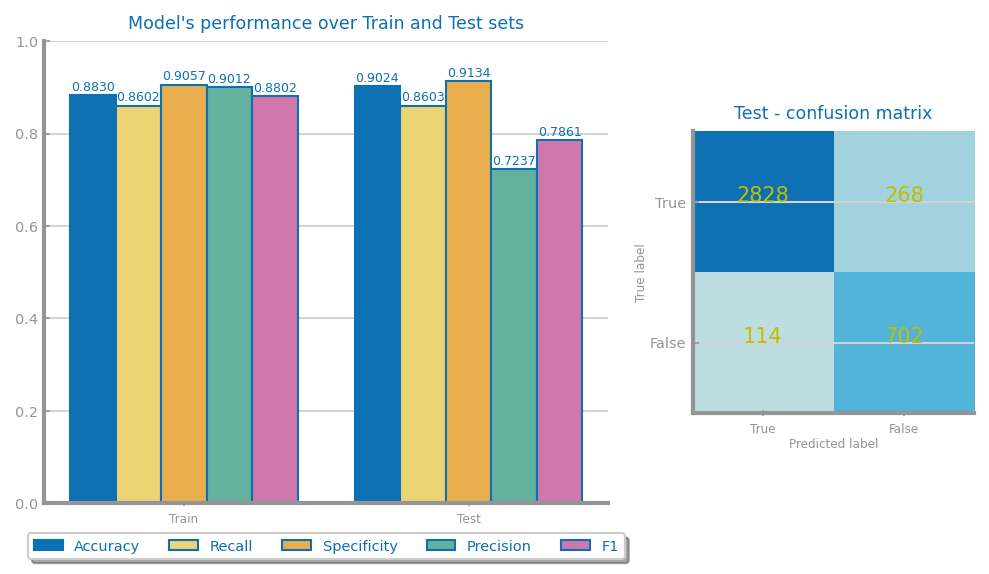

In [116]:
# NAIVE BAYES
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

iterations = train_config['iterations']

fit_time = []
pred_time = []
nb_train_predictions = []
nb_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_nb = BernoulliNB()
counter = 0
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)
    start_time = timeit.default_timer()
    clf_nb.fit(trnX, trnY)
    times['NB']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_nb.predict(trnX)
    # print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_nb.predict(tstX)
    times['NB']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    nb_train_predictions.append(prd_trn)
    nb_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'NB')

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}NB.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.0046731000002182554
train_predict time: 2.553454099999726
zpredict: 0.6867696999997861
1 zfit time: 0.0015536999999312684
train_predict time: 2.2900159000000713
zpredict: 0.6439846999983274
2 zfit time: 0.0021850999983143993
train_predict time: 2.2694274999994377
zpredict: 0.6683610000000044
3 zfit time: 0.0015480999991268618
train_predict time: 2.251395399998728
zpredict: 0.650443799999266
4 zfit time: 0.0015733000000182074
train_predict time: 2.188713199999256
zpredict: 0.629929999999149
5 zfit time: 0.0018460999999660999
train_predict time: 2.2262991000006878
zpredict: 0.6397550999990926
6 zfit time: 0.0016305999997712206
train_predict time: 2.173158200001126
zpredict: 0.6196908999991138
7 zfit time: 0.002153600000383449
train_predict time: 2.2436551000009786
zpredict: 0.6397314999994705
8 zfit time: 0.0031988999999157386
train_predict time: 2.258196199998565
zpredict: 0.6300129999999626
9 zfit time: 0.0016218000000662869
train_predict time: 2.1986682999995537
zpredic

<Figure size 600x450 with 0 Axes>

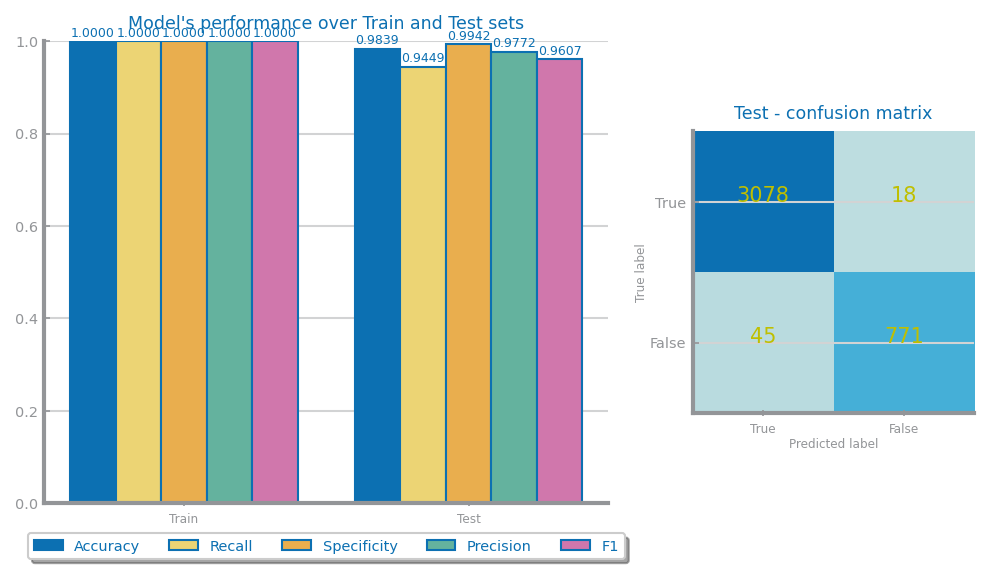

In [117]:
# KNN
from sklearn.neighbors import KNeighborsClassifier
iterations = train_config['iterations']
params = {
    'n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
    'metric': ['manhattan', 'euclidean', 'chebyshev'],
}

model = KNeighborsClassifier(n_jobs=-1)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['KNN'], model_name='KNN', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['KNN'], model_name='KNN', suffix=suffix)

knn_train_predictions = []
knn_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_knn = KNeighborsClassifier(n_neighbors=best[0], metric=best[1], n_jobs = -1)
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_knn.fit(trnX, trnY)
    times['KNN']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_knn.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_knn.predict(tstX)
    times['KNN']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    knn_train_predictions.append(prd_trn)
    knn_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'KNN')

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}knn.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.10594379999929515
train_predict time: 0.0014871000003040535
zpredict: 0.0007447000007232418
1 zfit time: 0.09399829999892972
train_predict time: 0.0015282999993360136
zpredict: 0.0005456999988382449
2 zfit time: 0.10175820000040403
train_predict time: 0.002920099999755621
zpredict: 0.0017549999993207166
3 zfit time: 0.13677289999941422
train_predict time: 0.002376999998887186
zpredict: 0.0010755999992397847
4 zfit time: 0.11717730000054871
train_predict time: 0.0017026000004989328
zpredict: 0.0009157000004051952
5 zfit time: 0.09593610000047192
train_predict time: 0.003225800001018797
zpredict: 0.0010320000001229346
6 zfit time: 0.08747670000047947
train_predict time: 0.001323100001172861
zpredict: 0.0006845999996585306
7 zfit time: 0.08762669999850914
train_predict time: 0.001792099999875063
zpredict: 0.000841200000650133
8 zfit time: 0.09207470000001194
train_predict time: 0.0013340999994397862
zpredict: 0.0004961000013281591
9 zfit time: 0.086644899998646
train_predic

<Figure size 600x450 with 0 Axes>

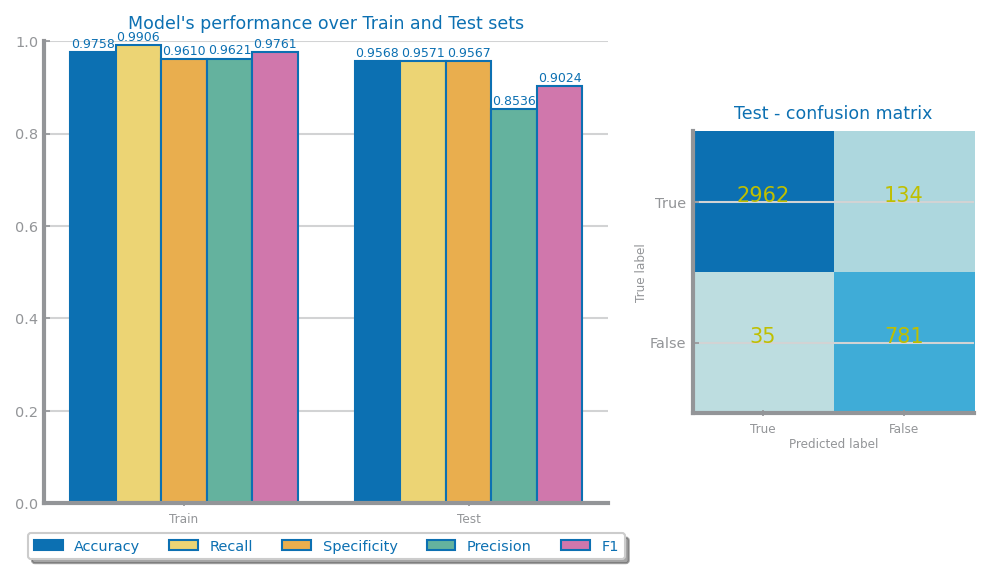

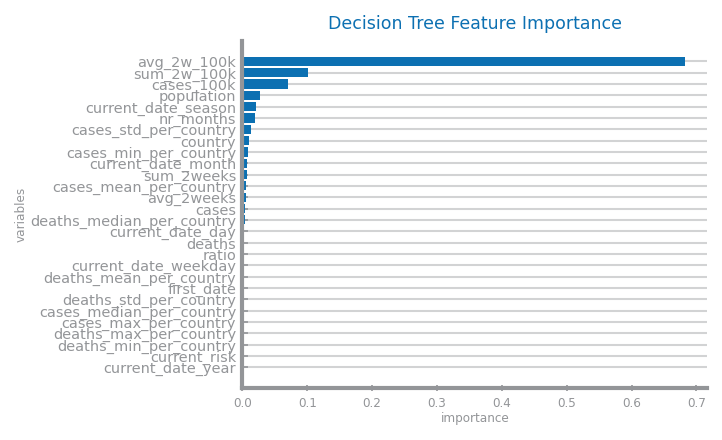

In [118]:
#  DECISION TREE
from sklearn.tree import DecisionTreeClassifier, plot_tree
iterations = train_config['iterations']
params = {
    'criterion': ['gini', 'entropy'],
    'min_impurity_decrease': [0.025, 0.01, 0.005, 0.0025, 0.001],
    'max_depth': [2, 5, 10, 15, 20, 25],
}

model = DecisionTreeClassifier(random_state = 0)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['DT'], model_name='DT', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['DT'], model_name='DT', suffix=suffix)

dt_train_predictions = []
dt_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_dt = DecisionTreeClassifier(criterion=best[0],min_impurity_decrease=best[1],max_depth=best[2],random_state=0)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_dt.fit(trnX, trnY)
    times['DT']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_dt.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_dt.predict(tstX)
    times['DT']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    dt_train_predictions.append(prd_trn)
    dt_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'DT')

    # plot_tree(clf_dt, feature_names=data.columns, class_names=['0','1'])
    # plt.savefig(f'{image_dir}dt/fold_{counter}_best_tree.png', dpi=300, bbox_inches='tight')

    variables = train.columns
    importances = clf_dt.feature_importances_
    importance_list.append(importances)
    # std = np.std([tree.feature_importances_ for tree in clf_dt.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}DT.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]

model_importances['DT'] = list(zip(elems,mean_importance[indices]))

fig = plt.figure()
ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Decision Tree Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}dt_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.9578332000000955
train_predict time: 0.15575709999939136
zpredict: 0.14383310000084748
1 zfit time: 0.9506213000004209
train_predict time: 0.3325808000008692
zpredict: 0.14390850000017963
2 zfit time: 0.9383538999991288
train_predict time: 0.14654459999837854
zpredict: 0.16254360000129964
3 zfit time: 0.9349330999993981
train_predict time: 0.15722959999948216
zpredict: 0.14986080000016955
4 zfit time: 0.910021499999857
train_predict time: 0.14399720000074012
zpredict: 0.14460800000051677
5 zfit time: 0.9458617000000231
train_predict time: 0.2270989999997255
zpredict: 0.13985240000147314
6 zfit time: 0.9391550999989704
train_predict time: 0.3293060999985755
zpredict: 0.13521680000121705
7 zfit time: 0.9173901000012847
train_predict time: 0.1434862999994948
zpredict: 0.1574185999998008
8 zfit time: 0.9434604000016407
train_predict time: 0.14500349999980244
zpredict: 0.17562050000015006
9 zfit time: 0.9479231999994226
train_predict time: 0.3316518999999971
zpredict: 0.13415

<Figure size 600x450 with 0 Axes>

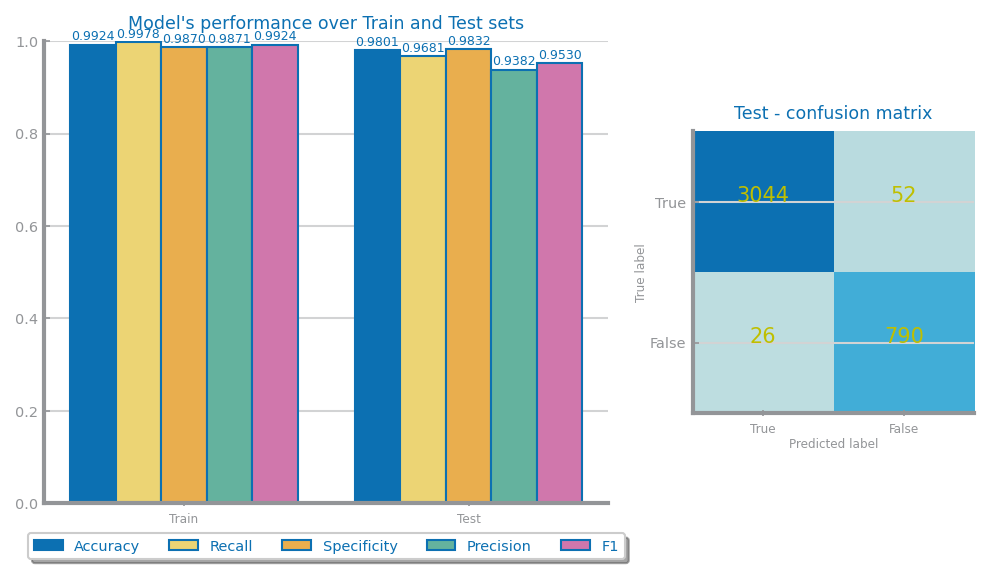

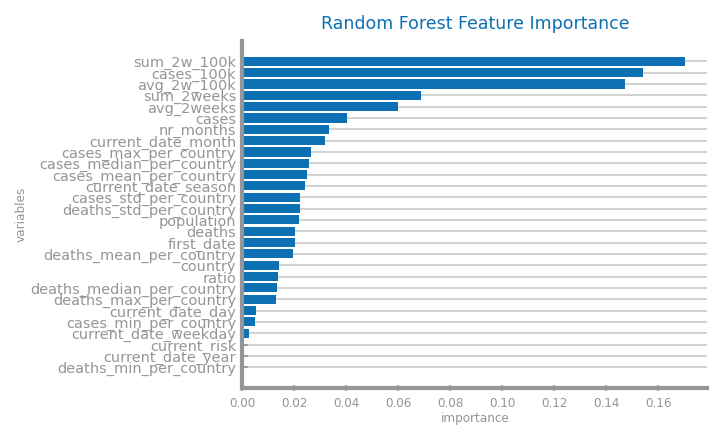

In [119]:
#  RANDOM FOREST

iterations = train_config['iterations']
params = {
    'max_depth' : [5,10,15],
    'max_features' : [.1, .3, .5, .7, .9, 1.0],
    'n_estimators' : [5, 10, 25, 50, 75, 100, 150],
}

model = RandomForestClassifier(random_state = 0, n_jobs = -1)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['RF'], model_name='RF', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['RF'], model_name='RF', suffix=suffix)

rf_train_predictions = []
rf_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_rf = RandomForestClassifier(max_depth=best[0],max_features=best[1],n_estimators=best[2],random_state=0, n_jobs=-1)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_rf.fit(trnX, trnY)
    times['RF']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_rf.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_rf.predict(tstX)
    times['RF']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    rf_train_predictions.append(prd_trn)
    rf_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'RF')

    variables = train.columns
    importances = clf_rf.feature_importances_
    importance_list.append(importances)
    std = np.std([tree.feature_importances_ for tree in clf_rf.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]
        # print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

    fig = plt.figure()
    ds.horizontal_bar_chart(elems, importances[indices], std[indices], title='Random Forest Features importance', xlabel='importance', ylabel='variables')
    # plt.savefig(f'{image_dir}rf/seed_{counter}_rf_ranking.png', dpi=300, bbox_inches = 'tight')
    plt.close(fig)

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}rf.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]

model_importances['RF'] = list(zip(elems,mean_importance[indices]))

fig = plt.figure()
ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Random Forest Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}RF_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

0 zfit time: 0.635991400000421
train_predict time: 0.005748000001403852
zpredict: 0.0017084999999497086
1 zfit time: 0.6344318999999814
train_predict time: 0.004187399999864283
zpredict: 0.002484099999492173
2 zfit time: 0.6394674000002851
train_predict time: 0.004025099999125814
zpredict: 0.001357799999823328
3 zfit time: 0.6328694000003452
train_predict time: 0.005425100000138627
zpredict: 0.0017683000005490612
4 zfit time: 0.642104599999584
train_predict time: 0.0066870000009657815
zpredict: 0.0015141999992920319
5 zfit time: 0.6445268000006763
train_predict time: 0.003960800000641029
zpredict: 0.0013613000010082033
6 zfit time: 0.633526300000085
train_predict time: 0.004462799999600975
zpredict: 0.0015912000017124228
7 zfit time: 0.6378077999997913
train_predict time: 0.0059834999992745
zpredict: 0.0015234999991662335
8 zfit time: 0.6289788000012777
train_predict time: 0.003987899999629008
zpredict: 0.0014365000006364426
9 zfit time: 0.6279505000002246
train_predict time: 0.0041458

<Figure size 600x450 with 0 Axes>

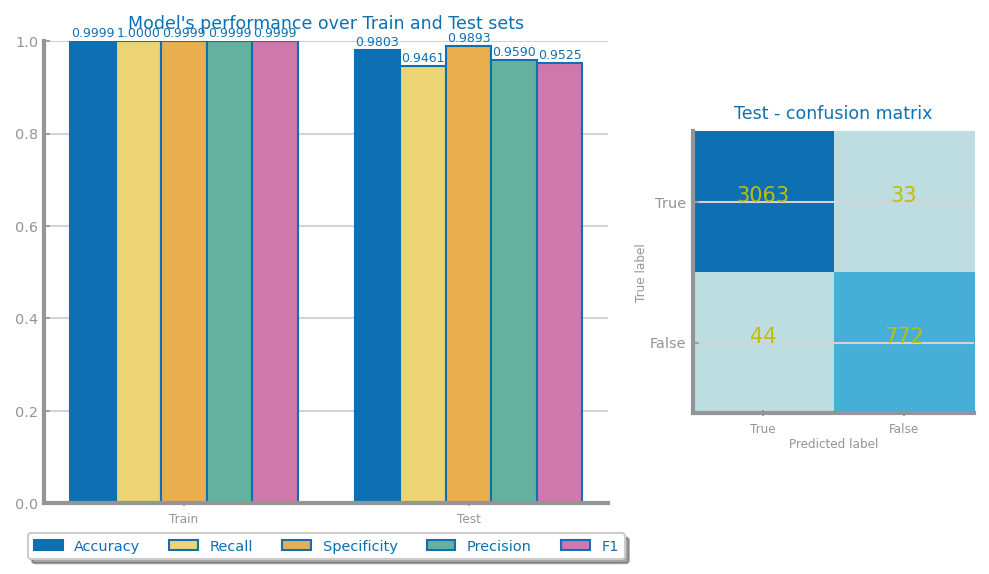

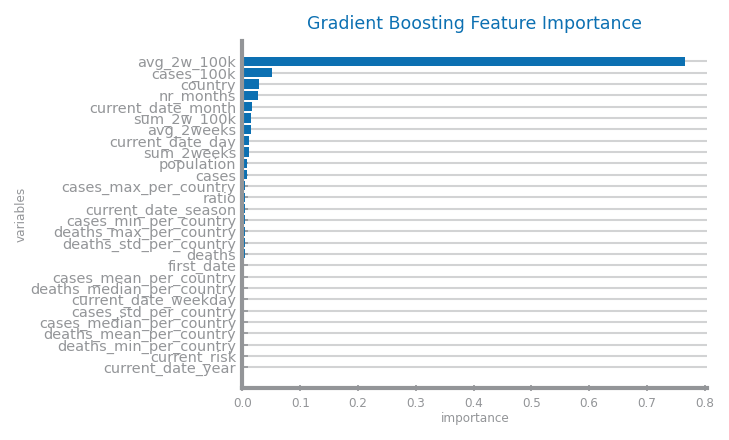

In [120]:
#  Gradient Boosting
from sklearn.ensemble import GradientBoostingClassifier

iterations = train_config['iterations']

params = {
    'n_estimators' : [5, 10, 25, 50, 75, 100, 200],
    'max_depth' : [5, 10, 25],
    'learning_rate' : [.1, .5, .9]
}

model = GradientBoostingClassifier(random_state = 0)
if train_test_avaliable:
    best = get_best_params_train_test(model=model, params=params, trnX=trnX, trnY=trnY, tstX=tstX, tstY=tstY, iterations = 1, train = train_config['GB'], model_name='GB', suffix=suffix)
else:
    best = get_best_params(model=model, params=params, X=X, y=y, iterations = 1, train = train_config['GB'], model_name='GB', suffix=suffix)

gb_train_predictions = []
gb_test_predictions = []
conf_matrix_trn_list = []
conf_matrix_tst_list = []
clf_gb = GradientBoostingClassifier(n_estimators=best[0], max_depth=best[1], learning_rate=best[2], random_state = 0)
counter = 0
importance_list = []
for i in range(iterations):
    print(i, end = ' ')
    counter += 1
    if not train_test_avaliable:
        trnX, tstX, trnY, tstY = train_test_split(X, y, stratify = y, test_size= 0.3, random_state = i)

    start_time = timeit.default_timer()
    clf_gb.fit(trnX, trnY)
    times['GB']['fit'].append(timeit.default_timer() - start_time)
    print(f"zfit time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_trn = clf_gb.predict(trnX)
    print(f"train_predict time: {timeit.default_timer() - start_time}")
    start_time = timeit.default_timer()
    prd_tst = clf_gb.predict(tstX)
    times['GB']['pred'].append(timeit.default_timer() - start_time)
    print(f"zpredict: {timeit.default_timer() - start_time}")
    gb_train_predictions.append(prd_trn)
    gb_test_predictions.append(prd_tst)
    conf_matrix_trn = ds.confusion_matrix(trnY, prd_trn)
    conf_matrix_tst = ds.confusion_matrix(tstY, prd_tst)
    conf_matrix_trn_list.append(conf_matrix_trn)
    conf_matrix_tst_list.append(conf_matrix_tst)
    model_scores = get_scores_fold(tstY,prd_tst,model_scores,'GB')

    variables = train.columns
    importances = clf_gb.feature_importances_
    importance_list.append(importances)
    # std = np.std([tree.feature_importances_ for tree in clf_gb.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    elems = []
    for f in range(trnX.shape[1]):
        elems += [variables[indices[f]]]
        # print(f'{f+1}. feature {elems[f]} ({importances[indices[f]]})')

    fig = plt.figure()
    ds.horizontal_bar_chart(elems, importances[indices], np.std(importance_list),title='Gradient Boosting Features importance', xlabel='importance', ylabel='variables')
    # plt.savefig(f'{image_dir}gb/seed_{counter}_gb_ranking.png', dpi=300, bbox_inches = 'tight')
    plt.close(fig)

fig = plt.figure()
conf_matrix_trn = np.mean(conf_matrix_trn_list, axis=0)
conf_matrix_tst = np.mean(conf_matrix_tst_list, axis=0)
plot_evaluation_results(labels, conf_matrix_trn, conf_matrix_tst)
plt.savefig(f'{image_dir}gb.png', dpi=300, bbox_inches = 'tight')

mean_importance = np.mean(importance_list,axis = 0)
std_importance = np.std(importance_list,axis = 0)
indices = np.argsort(mean_importance)[::-1]
elems = []
for f in range(trnX.shape[1]):
    elems += [variables[indices[f]]]
fig = plt.figure()

model_importances['GB'] = list(zip(elems,mean_importance[indices]))

ds.horizontal_bar_chart(elems, mean_importance[indices], std_importance[indices], title='Gradient Boosting Feature Importance', xlabel='importance', ylabel='variables')
plt.savefig(f'{image_dir}GB_mean_feature_importance.png', dpi=300, bbox_inches = 'tight')

In [121]:
scores = {
    'NB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'KNN': {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'DT':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'RF':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
    'GB':  {'precision': [], 'recall' : [], 'accuracy': [], 'auc': [], 'F1': []},
}
for i,v in model_scores.items():
    for m,v2 in v.items():
        mean = np.mean(v2)
        scores[i][m] = mean
print(scores)

{'NB': {'precision': 0.7237113402061855, 'recall': 0.8602941176470589, 'accuracy': 0.9023517382413088, 'auc': 0.8868654050767596, 'F1': 0.7861142217245242}, 'KNN': {'precision': 0.9771863117870723, 'recall': 0.9448529411764707, 'accuracy': 0.9838957055214724, 'auc': 0.9695194938440495, 'F1': 0.9607476635514018}, 'DT': {'precision': 0.853551912568306, 'recall': 0.957107843137255, 'accuracy': 0.9567995910020451, 'auc': 0.9569130946952423, 'F1': 0.9023685730791449}, 'RF': {'precision': 0.9382422802850355, 'recall': 0.9681372549019608, 'accuracy': 0.9800613496932515, 'auc': 0.975670694634443, 'F1': 0.9529553679131485}, 'GB': {'precision': 0.9590062111801242, 'recall': 0.9460784313725489, 'accuracy': 0.980316973415133, 'auc': 0.9677097583219336, 'F1': 0.9524984577421345}}


In [122]:
scores_n = {'precision' : [], 'recall' : [], 'accuracy' : [], 'auc' : [], 'F1' : []}

for k,v in scores.items():
    print(k,v)
    scores_n['precision'].append(v['precision'])
    scores_n['recall'].append(v['recall'])
    scores_n['accuracy'].append(v['accuracy'])
    scores_n['auc'].append(v['auc'])
    scores_n['F1'].append(v['F1'])

for v in scores_n.values():
    for i in v:
        print(i)

print()

for model_name, model_time in times.items():
    for operation, time_list in model_time.items():
        if operation != 'param':
            # print(model_name,operation)
            print(np.mean(time_list))

print() 

for model_name, model_time in times.items():
    for operation, time_list in model_time.items():
        if operation == 'param':
            # print(model_name,operation)
            print(np.mean(time_list))

print()

print(model_importances)

NB {'precision': 0.7237113402061855, 'recall': 0.8602941176470589, 'accuracy': 0.9023517382413088, 'auc': 0.8868654050767596, 'F1': 0.7861142217245242}
KNN {'precision': 0.9771863117870723, 'recall': 0.9448529411764707, 'accuracy': 0.9838957055214724, 'auc': 0.9695194938440495, 'F1': 0.9607476635514018}
DT {'precision': 0.853551912568306, 'recall': 0.957107843137255, 'accuracy': 0.9567995910020451, 'auc': 0.9569130946952423, 'F1': 0.9023685730791449}
RF {'precision': 0.9382422802850355, 'recall': 0.9681372549019608, 'accuracy': 0.9800613496932515, 'auc': 0.975670694634443, 'F1': 0.9529553679131485}
GB {'precision': 0.9590062111801242, 'recall': 0.9460784313725489, 'accuracy': 0.980316973415133, 'auc': 0.9677097583219336, 'F1': 0.9524984577421345}
0.7237113402061855
0.9771863117870723
0.853551912568306
0.9382422802850355
0.9590062111801242
0.8602941176470589
0.9448529411764707
0.957107843137255
0.9681372549019608
0.9460784313725489
0.9023517382413088
0.9838957055214724
0.956799591002045

In [193]:
# a = pd.DataFrame(model_scores).reset_index()
# b = pd.melt(a, id_vars="index", var_name="model", value_name="score")
# c = b.explode('score')

# darkblue = '#0C70B2'


# plt.figure(figsize=(7.5,3))
# ax = sns.barplot(x='index', y='score', hue='model', data=c, ci = 'sd', errwidth=1, edgecolor = darkblue)
# ax.set_title('Baseline Model Scores')
# for i in range(len(ax.containers)):
#     ax.bar_label(ax.containers[i], fmt = '%1.4f', fontsize = 6)
# ax.legend(fontsize='x-small', title_fontsize='small', loc='upper center', bbox_to_anchor=(0.5, -0.05),
#           fancybox=True, shadow=True, ncol=5)
# # plt.savefig(f'{image_dir}/{suffix}_scores.png', dpi=300, bbox_inches = 'tight')
